In [11]:
import os
import pprint
import argparse
import glob

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import sys
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd())))

import lib.models as models
from lib.config import config, update_config
from lib.utils import utils
from lib.datasets import get_dataset
from lib.core import function

import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy.spatial import distance

%matplotlib inline

In [2]:
def runTTA(trialname):
    os.chdir("/media/D/netanell/HRNet-Facial-Landmark-Detection/")
    cfg_file = glob.glob(os.path.join("/media/D/netanell/HRNet-Facial-Landmark-Detection/experiments/fetal/Trials/", trialname+"*.yaml"))[0]
    config.defrost()
    config.merge_from_file(cfg_file)
    config.DATASET.ROOT = config.DATASET.ROOT + "_TTA"
    config.DATASET.TESTSET = config.DATASET.TESTSET.replace("_test", "_test_tta")
    config.freeze()
    
    exp_dir = os.path.join("/media/D/netanell/HRNet-Facial-Landmark-Detection/output/FETAL/", os.path.basename(cfg_file).split(".")[0])
    model_file = glob.glob(os.path.join(exp_dir, "final_state.pth"))[0]
    
    logger, final_output_dir, tb_log_dir = \
        utils.create_logger(config, cfg_file, 'testTTA')

    logger.info(pprint.pformat(config))

    cudnn.benchmark = config.CUDNN.BENCHMARK
    cudnn.determinstic = config.CUDNN.DETERMINISTIC
    cudnn.enabled = config.CUDNN.ENABLED

    config.defrost()
    config.MODEL.INIT_WEIGHTS = False
    config.freeze()
    model = models.get_face_alignment_net(config)

    gpus = list(config.GPUS)
    model = nn.DataParallel(model, device_ids=gpus).cuda()

    # load model
    state_dict = torch.load(model_file)
    if 'state_dict' in state_dict.keys():
        state_dict = state_dict['state_dict']
        model.load_state_dict(state_dict)
    else:
        model.module.load_state_dict(state_dict)

    dataset_type = get_dataset(config)

    test_loader = DataLoader(
        dataset=dataset_type(config,
                             is_train=False),
        batch_size=config.TEST.BATCH_SIZE_PER_GPU*len(gpus),
        shuffle=False,
        num_workers=config.WORKERS,
        pin_memory=config.PIN_MEMORY
    )

    nme, predictions = function.inference(config, test_loader, model)

    torch.save(predictions, os.path.join(final_output_dir, 'predictionsTTA.pth'))

In [3]:
from sklearn.cluster import DBSCAN, KMeans
def show_after_cluster(image, pts_tf_out):
    plt.figure()
    pts_tf_concat = np.concatenate(pts_tf_out)
    plt.imshow(image)
    db =  DBSCAN(eps=4, min_samples=4).fit(pts_tf_concat)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = pts_tf_concat[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=5)

        xy = pts_tf_concat[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=0)
    
    pts_no_outliers = pts_tf_concat[core_samples_mask]
    k_means = KMeans(n_clusters=2)
    y_pred = k_means.fit_predict(pts_no_outliers)
    
    plt.figure()
    plt.imshow(image)
    
    plt.scatter(pts_no_outliers[:, 0], pts_no_outliers[:, 1], c=y_pred)
    
    plt.figure()
    plt.imshow(image)
    for k in k_means.cluster_centers_:
         plt.plot(k[0], k[1], 'o', markerfacecolor='r',
            markeredgecolor='k', markersize=6)
    return k_means.cluster_centers_

In [9]:
def analyze_tta(datatype, trialname, display=True):
    predictions = torch.load("/media/D/netanell/HRNet-Facial-Landmark-Detection/output/FETAL/"+trialname+"/predictionsTTA.pth")
    OUTPUT_PNG_DIR = "/media/D/netanell/HRNet-Facial-Landmark-Detection/data/fetal/NewDB/"+datatype.upper()+"/"
    df_for_hrnet = pd.read_csv("/media/D/netanell/HRNet-Facial-Landmark-Detection/data/fetal/NewDB/alldata_"+datatype+"_test.csv")
    meases = []
    for j, elem in df_for_hrnet.iterrows():
        sub_pred = predictions[j*(int(360/30)):(j+1)*int(360/30)].cpu().numpy()
        image = cv2.imread(os.path.join(OUTPUT_PNG_DIR, elem["image_name"]))
        pts_tf_out = []
        if display:
            plt.figure()
            plt.imshow(image)
        for i, angle in enumerate(range(0,360,30)):
            image_center = (elem['center_h'] , elem['center_w'])
            rot_mat = cv2.getRotationMatrix2D(image_center, -angle, 1.0)
            pts = sub_pred[i]
            pts_tf = cv2.transform(np.expand_dims(pts.T, axis=2).T, rot_mat)
            pts_tf = np.squeeze(pts_tf).T
            pts_tf_out.append(pts_tf.T)

        pts_tf_stack = np.stack(pts_tf_out)
        if display:
            plt.plot( pts_tf_stack[:,0,0], pts_tf_stack[:,0,1], 'b.', alpha=.5, label='right')
            plt.plot( pts_tf_stack[:,1,0], pts_tf_stack[:,1,1], 'g.', alpha=.5, label='left')
            plt.legend()
        res_pts = show_after_cluster(image, pts_tf_out)

        x1_point = int(df_for_hrnet.loc[j,datatype.lower()+'_1_x'])
        y1_point = int(df_for_hrnet.loc[j,datatype.lower()+'_1_y'] )
        x2_point = int(df_for_hrnet.loc[j,datatype.lower()+'_2_x'])
        y2_point = int(df_for_hrnet.loc[j,datatype.lower()+'_2_y'] )
        if display:
            plt.plot( (x1_point, x2_point), (y1_point,y2_point), 'b-')
            plt.plot( res_pts[:,0], res_pts[:,1], 'g-')
        orig_pts = np.array(( (x1_point, x2_point), (y1_point,y2_point)))
        p1, p2 = distance.euclidean(orig_pts.T[0], orig_pts.T[1],) , distance.euclidean(res_pts[0], res_pts[1],)
        pix_size = float(elem["image_name"].split("Res")[1].split("_")[0])
        p1 , p2 = p1 * pix_size, p2*pix_size
        meases.append((p1,p2))#, elem.origalgo))
    return meases

In [ ]:
#RESULTS = {}
for datatype in ["tcd",]: #["cbd", "bbd", "tcd"]:
    for trialtype in ["FUSE_ASSIGN", "MSE_ASSIGN", "FUSE_noASSIGN", "MSE_noASSIGN"]:
        trialname = "fetal_landmark_hrnet_w18_"+datatype+"_learn_test_"+trialtype
        runTTA(trialname)
        RESULTS[trialname] = analyze_tta(datatype, trialname, display=False)

In [9]:
cbd_curr = glob.glob("/media/D/netanell/HRNet-Facial-Landmark-Detection/experiments/fetal/Trials/fetal_landmark_hrnet_w18_cbd*")[0]

In [20]:
config.defrost()
config.merge_from_file(cbd_curr)
config.DATASET.ROOT = config.DATASET.ROOT + "_TTA"
config.DATASET.TESTSET = config.DATASET.TESTSET.replace("_test", "_test_tta")
config.freeze()

In [29]:
exp_dir = os.path.join("/media/D/netanell/HRNet-Facial-Landmark-Detection/output/FETAL/", os.path.basename(cbd_curr).split(".")[0])
model_file = glob.glob(os.path.join(exp_dir, "final_state.pth"))[0]

fetal_landmark_hrnet_w18_cbd_learn_test_FUSE_ASSIGN 0.9983621727202685
fetal_landmark_hrnet_w18_cbd_learn_test_MSE_ASSIGN 0.806862030053214
fetal_landmark_hrnet_w18_cbd_learn_test_FUSE_noASSIGN 1.0077904886738902
fetal_landmark_hrnet_w18_cbd_learn_test_MSE_noASSIGN 0.8451835356208374
fetal_landmark_hrnet_w18_bbd_learn_test_FUSE_ASSIGN 2.6581336489577008
fetal_landmark_hrnet_w18_bbd_learn_test_MSE_ASSIGN 0.9710932244739635
fetal_landmark_hrnet_w18_bbd_learn_test_FUSE_noASSIGN 0.9387755710917123
fetal_landmark_hrnet_w18_bbd_learn_test_MSE_noASSIGN 5.193143974657493
fetal_landmark_hrnet_w18_tcd_learn_test_FUSE_ASSIGN 0.5491797244966672
fetal_landmark_hrnet_w18_tcd_learn_test_MSE_ASSIGN 0.4300141491644026
fetal_landmark_hrnet_w18_tcd_learn_test_FUSE_noASSIGN 0.5231141762897614
fetal_landmark_hrnet_w18_tcd_learn_test_MSE_noASSIGN 0.4816475123496518


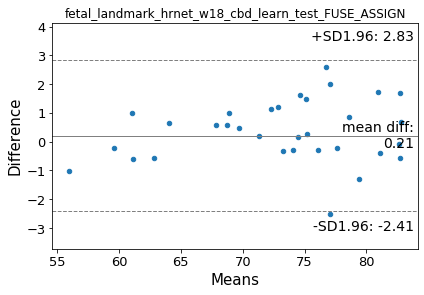

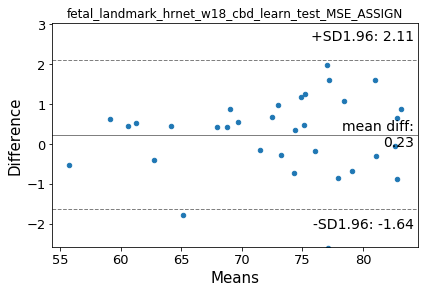

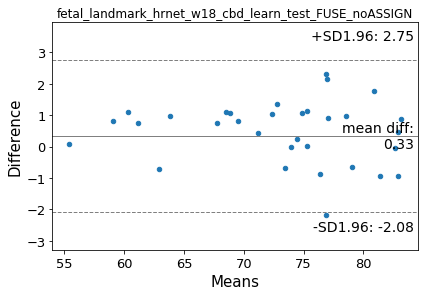

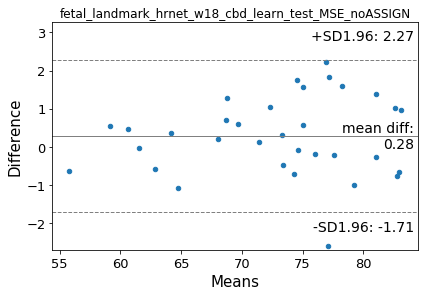

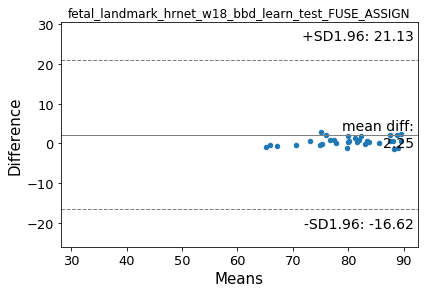

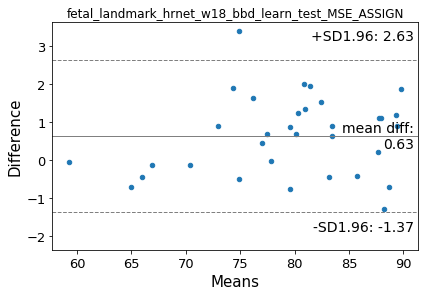

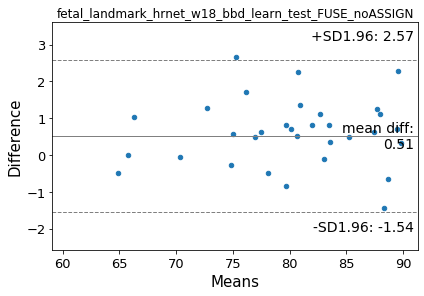

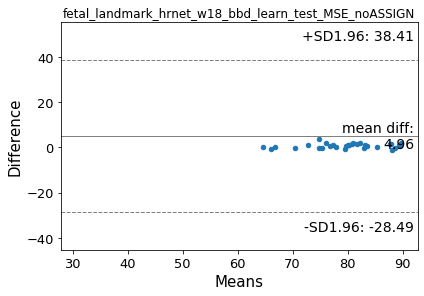

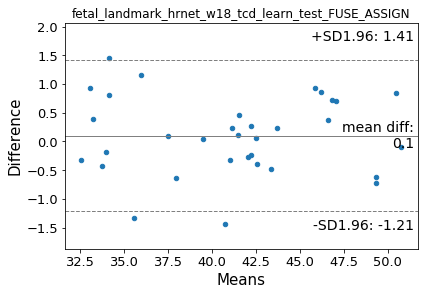

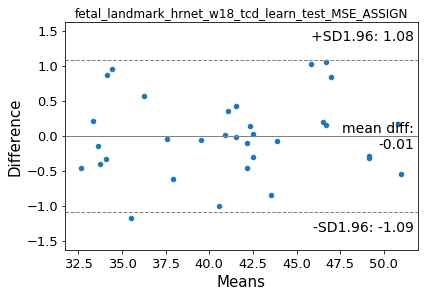

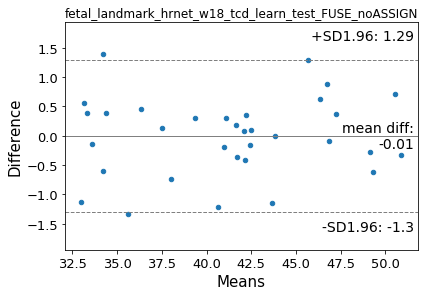

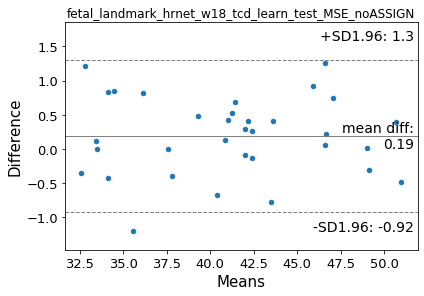

In [24]:
import statsmodels.api as sm


for k,v in RESULTS.items():
    mmm = np.array(v)
    sm.graphics.mean_diff_plot(mmm[:,0], mmm[:,1])
    plt.title(k)
    print (k, np.mean(np.abs(mmm[:,0] - mmm[:,1])))

In [20]:
def createTTAdataset(data_type):
    #Create evaluationTTA excel
    OUTPUT_PNG_DIR = "/media/D/netanell/HRNet-Facial-Landmark-Detection/data/fetal/NewDB/"+datatype.upper()+"/"
    OUTPUT_TTA_PNG_DIR = "/media/D/netanell/HRNet-Facial-Landmark-Detection/data/fetal/NewDB/"+datatype.upper()+"_TTA/"
    os.makedirs(OUTPUT_TTA_PNG_DIR, exist_ok=True)

    out_dict_list = []

    df_for_hrnet_all = pd.read_csv("/media/D/netanell/HRNet-Facial-Landmark-Detection/data/fetal/NewDB/alldata_"+datatype.lower()+"_test.csv")
    for i, elem in df_for_hrnet_all.iterrows():
        image = cv2.imread(os.path.join(OUTPUT_PNG_DIR, elem["image_name"]))
        x1_point = int(df_for_hrnet_all.loc[i,datatype.lower()+'_1_x'])
        y1_point = int(df_for_hrnet_all.loc[i,datatype.lower()+'_1_y'] )
        x2_point = int(df_for_hrnet_all.loc[i,datatype.lower()+'_2_x'])
        y2_point = int(df_for_hrnet_all.loc[i,datatype.lower()+'_2_y'] )
        image_center = (elem['center_w'] , elem['center_h'])

        #Plot original
        plt.figure()
        plt.imshow(image)
        plt.plot( (x1_point, x2_point), (y1_point,y2_point), 'b-')
        for angle in range(0,360,30):

            rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
            result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
            newname = "rot{}_".format(angle)+elem['image_name']
            cv2.imwrite(os.path.join(OUTPUT_TTA_PNG_DIR, newname), result)


            pts = np.array(((x1_point, y1_point), (x2_point, y2_point)))
            pts_tf = cv2.transform(np.expand_dims(pts.T, axis=2).T, rot_mat)

            pts_tf = np.squeeze(pts_tf)
            out_dict = {"image_name": newname,
                        "scale": df_for_hrnet_all.loc[i,'scale'],
                        "center_w": elem['center_w'],
                        "center_h": elem['center_h'],
                        datatype.lower()+"_1_x": pts_tf[0,0],
                        datatype.lower()+"_1_y": pts_tf[0,1],
                        datatype.lower()+"_2_x": pts_tf[1,0],
                        datatype.lower()+"_2_y": pts_tf[1,1],
            }
            out_dict_list.append(out_dict)
            plt.figure()
            plt.imshow(result)
            plt.plot( pts_tf[:,0], pts_tf[:,1], 'b-')
    pd.DataFrame(out_dict_list).to_csv("/media/D/netanell/HRNet-Facial-Landmark-Detection/data/fetal/NewDB/alldata_"+data_type.lower()+"_test_tta.csv", index=False)

In [ ]:
createTTAdataset("tcd")

tcd 1.078656393378804 31
cbd 1.2855034685071325 31
bbd 1.1366131705367448 31


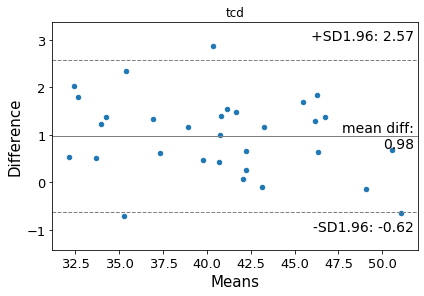

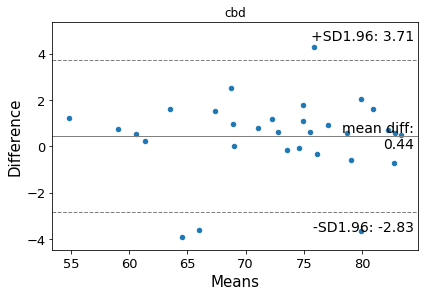

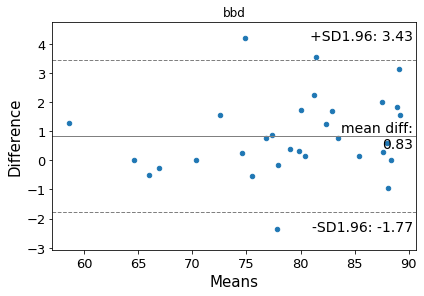

In [39]:
for datatype in ["tcd", "cbd", "bbd"]:
    df_for_hrnet = pd.read_csv("/media/D/netanell/HRNet-Facial-Landmark-Detection/data/fetal/NewDB/alldata_"+datatype+"_test.csv")
    df_algo = pd.read_csv("/media/df3-dafna/Netanell/MEDIA/result_13_5_try2/after_cluster.csv")
    dataelemslot = "MagicLiat"+datatype.upper()
    mmmo = []
    for j, elem in df_for_hrnet.iterrows():
        algo_line = df_algo.loc[df_algo['Unnamed: 0'].str.lower() == elem["image_name"].lower()[:-4]]

        if ~np.isnan(algo_line[dataelemslot].tolist()[0]):
            df_for_hrnet.loc[j, 'origalgo'] = algo_line[dataelemslot].tolist()[0]
        else:
            df_for_hrnet.loc[j, 'origalgo'] = -1
        mmmo.append(df_for_hrnet.loc[j, 'origalgo'])
    relevant_slot = np.array(RESULTS[[a for a in RESULTS.keys() if datatype in a][0]])
    mmmo = np.array(mmmo)
    k = (mmmo != -1)
    
    sm.graphics.mean_diff_plot(relevant_slot[k,0],mmmo[k])
    plt.title(datatype)
    print (datatype, np.mean(np.abs(relevant_slot[k,0] - mmmo[k])) , np.sum(k))
        
    

In [30]:
mmmo

[49.125567070925506,
 -1.0,
 46.04033571033122,
 40.25023888674451,
 43.20726081065542,
 37.01911201055477,
 44.6436214688056,
 35.64132692381136,
 33.34122335967893,
 38.8848857800817,
 36.24423668502345,
 42.65067966867585,
 38.34380760905207,
 39.561872113943245,
 33.404572640882556,
 42.044172432811656,
 50.20611286626361,
 40.121105325377066,
 45.984002067675675,
 31.880486725425005,
 51.38198525991382,
 45.35579406536721,
 45.49268266303934,
 40.897155776410656,
 40.46198745217541,
 34.21372948101391,
 31.73284757975559,
 31.392515712507013,
 41.886653905510286,
 40.39368525004867,
 42.0965476289921,
 -1.0,
 33.530687055889565]

['fetal_landmark_hrnet_w18_tcd_learn_test_FUSE_ASSIGN',
 'fetal_landmark_hrnet_w18_tcd_learn_test_MSE_ASSIGN',
 'fetal_landmark_hrnet_w18_tcd_learn_test_FUSE_noASSIGN',
 'fetal_landmark_hrnet_w18_tcd_learn_test_MSE_noASSIGN']